In [1]:
import pickle 
import yaml
import pandas as pd
from PrepareData import prepare_data


import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import seaborn as sns
from architecture import CLIP
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [2]:
from train_utils import load_model

In [3]:
def make_deterministic(random_seed = 0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    
make_deterministic(0)

In [3]:
config = yaml.safe_load(open('./checkpoints/FULL_COMBINED/config.yaml', 'r'))
logs = pickle.load(open('./checkpoints/FULL_COMBINED/logs.pickle', 'rb'))
for key in logs:
    if "best" in key:
        print(key, logs[key])

best_epoch 618
best_clip_epoch 684
best_recon_epoch 195
best_total_loss 0.05993457242846489
best_clip_loss 0.012829888865817339
best_recon_loss 0.039655369743704795


In [4]:
model = load_model(config['train']['checkpoint_dir'], type="best_total")
model = model.eval()
dataloaders, max_charge, num_species = prepare_data(config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
model = load_model(config['train']['checkpoint_dir'], type="best_clip")
model = model.eval()

In [6]:
val_ids = pickle.load(open('./checkpoints/FULL_COMBINED/val_ids.pickle', 'rb'))

In [7]:
all_ids = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        all_ids.append(data['index'].detach().cpu())
all_ids = torch.cat(all_ids, 0)

50it [00:00, 68.85it/s] 


In [8]:
assert(((val_ids.sort()[0] == all_ids.sort()[0]).sum() / all_ids.shape[0]).item())

In [9]:
from train_utils import decoder_performance
from train_utils import top_scores, decoder_performance, distance_distribution

def clip_performance(config, model, dataloaders, epoch):
    # model.to(device)
    model.eval()
    max_charge = config['data']['max_charge']
    num_species = config['data']['num_species']

    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
            specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids

    test_molembeds = torch.cat(molembeds, 0)
    test_specembeds = torch.cat(specembeds, 0)
    
    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['train'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
                # specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids
    
    train_molembeds = torch.cat(molembeds, 0)

    return test_molembeds, train_molembeds, test_specembeds

In [10]:
from train_utils import Sampler, calculate_decoder_accuracy

In [11]:
sampler = Sampler( model.module.smiles_decoder, model.module.vocab)

In [12]:
# def calculate_decoder_accuracy( model, dataloaders, k=1, greedy_decode=True):
#     pred_smiles_list = []
#     og_smiles_list = []
#     validity =0
#     validity_count = 0
#     count = 0
#     sampler = Sampler(model.module.smiles_decoder, model.module.vocab)
#     with torch.no_grad():
#         for i, data in tqdm(enumerate(dataloaders['val'])):
#             data = {k: v.to(device) for k, v in data.items()}
#             spec_latents = model.module.forward_spec(data)
#             for spec, og in zip(spec_latents, data['smiles'] ):
#                 ls = sampler.sample_multi(k,spec,greedy_decode=greedy_decode)
#                 validity_count += k
#                 generated_smiles = []
#                 for smi in ls:
#                     if smi != None:
#                         validity += 1
                
#             print("Validity", validity / validity_count)


In [13]:
# calculate_decoder_accuracy(model, dataloaders, k=1, greedy_decode=True)

In [15]:
def calculate_decoder_accuracy( model, dataloaders, k=1, greedy_decode=True):
    pred_smiles_list = []
    og_smiles_list = []
    validity = []
    validity_count = 0
    count = 0
    sampler = Sampler(model.module.smiles_decoder, model.module.vocab)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):
            data = {k: v.to(device) for k, v in data.items()}
            spec_latents = model.module.forward_spec(data)
            for spec, og in zip(spec_latents, data['smiles'] ):
                ls = sampler.sample_multi(k,spec,greedy_decode=greedy_decode)
                generated_smiles = []
                for smi in ls:
                    try:
                        generated_smiles.append(Chem.CanonSmiles(smi))
                    except:
                        pass
                og_smile = ""
                chars = model.module.vocab.from_seq(og)
                for char in chars:
                    if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                        og_smile += char
                try:
                    og_smile = Chem.CanonSmiles(og_smile)
                except:
                    pass
                
                if og_smile in generated_smiles:
                    count += 1
                
                og_smiles_list.append(og_smile)
                pred_smiles_list.append(generated_smiles)
            print("No of Hits : ",count / len(og_smiles_list))

        return count / len(og_smiles_list)

In [16]:
acc = calculate_decoder_accuracy(model, dataloaders, k=1, greedy_decode=True)

1it [00:19, 19.67s/it]

No of Hits :  0.53


2it [00:37, 18.65s/it]

No of Hits :  0.51125


3it [00:56, 18.57s/it]

No of Hits :  0.49


4it [01:14, 18.47s/it]

No of Hits :  0.489375


5it [01:32, 18.40s/it]

No of Hits :  0.4835


6it [01:50, 18.28s/it]

No of Hits :  0.4866666666666667


7it [02:08, 18.23s/it]

No of Hits :  0.4860714285714286


8it [02:27, 18.22s/it]

No of Hits :  0.48625


9it [02:44, 18.07s/it]

No of Hits :  0.4922222222222222


10it [03:02, 18.05s/it]

No of Hits :  0.48775


11it [03:20, 18.01s/it]

No of Hits :  0.49068181818181816


12it [03:38, 18.01s/it]

No of Hits :  0.49083333333333334


13it [03:56, 18.03s/it]

No of Hits :  0.49096153846153845


14it [04:14, 18.06s/it]

No of Hits :  0.4903571428571429


15it [04:33, 18.12s/it]

No of Hits :  0.49366666666666664


16it [04:51, 18.18s/it]

No of Hits :  0.493125


17it [05:09, 18.09s/it]

No of Hits :  0.49470588235294116


18it [05:27, 18.16s/it]

No of Hits :  0.49319444444444444


19it [05:45, 18.06s/it]

No of Hits :  0.4928947368421053


20it [06:03, 18.03s/it]

No of Hits :  0.493625


21it [06:21, 18.06s/it]

No of Hits :  0.49464285714285716


22it [06:39, 18.09s/it]

No of Hits :  0.4943181818181818


23it [06:57, 18.03s/it]

No of Hits :  0.4940217391304348


24it [07:16, 18.25s/it]

No of Hits :  0.49375


25it [07:34, 18.20s/it]

No of Hits :  0.4931


26it [07:52, 18.19s/it]

No of Hits :  0.49432692307692305


27it [08:10, 18.20s/it]

No of Hits :  0.49314814814814817


28it [08:29, 18.20s/it]

No of Hits :  0.4928571428571429


29it [08:47, 18.21s/it]

No of Hits :  0.4936206896551724


30it [09:05, 18.13s/it]

No of Hits :  0.49416666666666664


31it [09:23, 18.05s/it]

No of Hits :  0.4940322580645161


32it [09:41, 18.02s/it]

No of Hits :  0.493046875


33it [09:59, 17.99s/it]

No of Hits :  0.4932575757575758


34it [10:17, 18.00s/it]

No of Hits :  0.4935294117647059


35it [10:35, 18.01s/it]

No of Hits :  0.4937142857142857


36it [10:53, 17.99s/it]

No of Hits :  0.4945833333333333


37it [11:11, 18.06s/it]

No of Hits :  0.4950675675675676


38it [11:29, 18.07s/it]

No of Hits :  0.4943421052631579


39it [11:47, 18.00s/it]

No of Hits :  0.49416666666666664


40it [12:05, 18.01s/it]

No of Hits :  0.4950625


41it [12:23, 18.13s/it]

No of Hits :  0.494390243902439


42it [12:41, 18.08s/it]

No of Hits :  0.49351190476190476


43it [12:59, 18.03s/it]

No of Hits :  0.49436046511627907


44it [13:17, 17.99s/it]

No of Hits :  0.49357954545454547


45it [13:35, 17.97s/it]

No of Hits :  0.49333333333333335


46it [13:53, 17.95s/it]

No of Hits :  0.4926086956521739


47it [14:11, 18.02s/it]

No of Hits :  0.4928723404255319


48it [14:29, 18.00s/it]

No of Hits :  0.493125


49it [14:47, 18.00s/it]

No of Hits :  0.4937755102040816


50it [15:05, 18.10s/it]

No of Hits :  0.4928


50it [15:06, 18.12s/it]


In [17]:
# count = 0
# for a,b in zip(greedy_smiles_list, random_smiles_list):
#     if a != b:
#         count += 1
#         print(a,b)
# print(count)

NameError: name 'greedy_smiles_list' is not defined

In [26]:
greedy_smiles_list = []
og_smiles_list = []
random_smiles_list = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        spec_latents = model.module.forward_spec(data)
        for spec, og in zip(spec_latents, data['smiles'] ):
            og_smile = ""
            chars = model.module.vocab.from_seq(og)
            for char in chars:
                if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                    og_smile += char
            og_smile = Chem.CanonSmiles(og_smile)

            greedy_smiles = sampler.sample_multi(n=1,embed=spec,greedy_decode=True)
            greedy_smiles_list.append(greedy_smiles)
            
            random_smiles = sampler.sample_multi(n=3,embed=spec,greedy_decode=False)
            random_smiles_list.append(random_smiles)
            
            og_smiles_list.append(og_smile)
        # if i == 10:
        #     break
            

50it [1:00:46, 72.93s/it]


In [27]:
from rdkit import DataStructs
# from rdkit import AllChem
from rdkit.Chem import rdMolDescriptors,AllChem
def molecule_similarity(mol1, mol2, radius=2, nBits=1024,
                                      useChirality=False):
    try:
        mol1 = Chem.MolFromSmiles(mol1)
        mol2 = Chem.MolFromSmiles(mol2)
        fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1, radius=radius,
                                                            nBits=nBits,
                                                            useChirality=useChirality)
        fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2,
                                                                radius=radius,
                                                            nBits=nBits,
                                                            useChirality=useChirality)
        # fpgen = AllChem.GetRDKitFPGenerator()
        # fp1 = fpgen.GetFingerprint(mol1)
        # fp2 = fpgen.GetFingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return 0

In [47]:
sims = []
sims_labels = []

arr = []
for og_smile, greedy_smiles, random_smiles in zip(og_smiles_list, greedy_smiles_list, random_smiles_list):
    if molecule_similarity(og_smile, greedy_smiles[0]) !=1 and molecule_similarity(greedy_smiles[0], random_smiles[0]) != 1:
        arr.append(Chem.MolFromSmiles(og_smile))
        arr.append(Chem.MolFromSmiles(greedy_smiles[0]))
        for smi in random_smiles:
            arr.append(Chem.MolFromSmiles(smi))
        sim = molecule_similarity(random_smiles[0], greedy_smiles[0])
        if sim != 1:
            v = [Chem.MolFromSmiles(og_smile)]
            sim1 = molecule_similarity(og_smile, greedy_smiles[0])
            sim2 = molecule_similarity(og_smile, random_smiles[0])
            if sim1 != 1 and sim2 != 1 and sim1!=0 and sim2 != 0:
                sims.append(sim1)
                sims_labels.append("greedy")
                sims.append(sim2)
                sims_labels.append("random_sampling")  



In [48]:
len(arr)

3435

In [49]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
opts = Draw.DrawingOptions()
Draw.SetComicMode(opts)

img = Draw.MolsToGridImage(arr[60:80], molsPerRow=5, returnPNG=False)
img.save('./images/Decoder_rdkit_vis.png' )

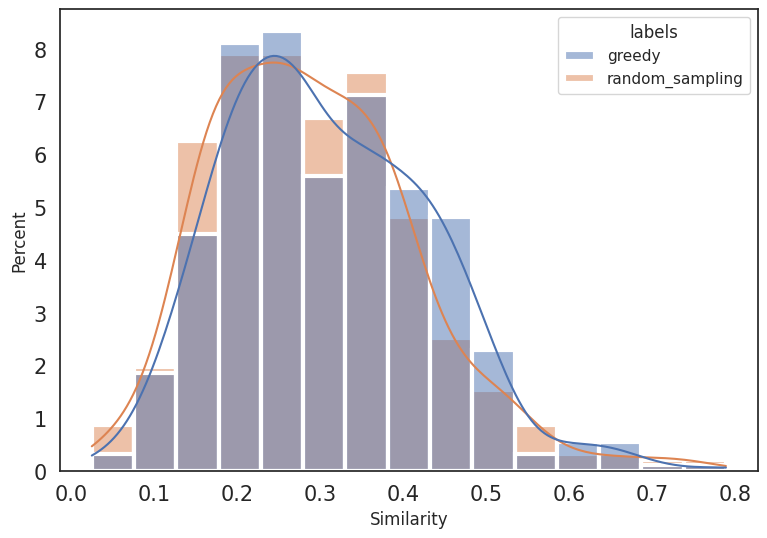

In [58]:
df = pd.DataFrame()
df['Similarity'] = sims
df['labels'] = sims_labels
%matplotlib inline
sns.set(rc={'figure.figsize':(9,6)})
sns.set_style("white")
sns.histplot(df, x='Similarity', hue='labels', bins=15, stat="percent", kde=True, linewidth=3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('./images/tanimotosim.png', dpi=300)


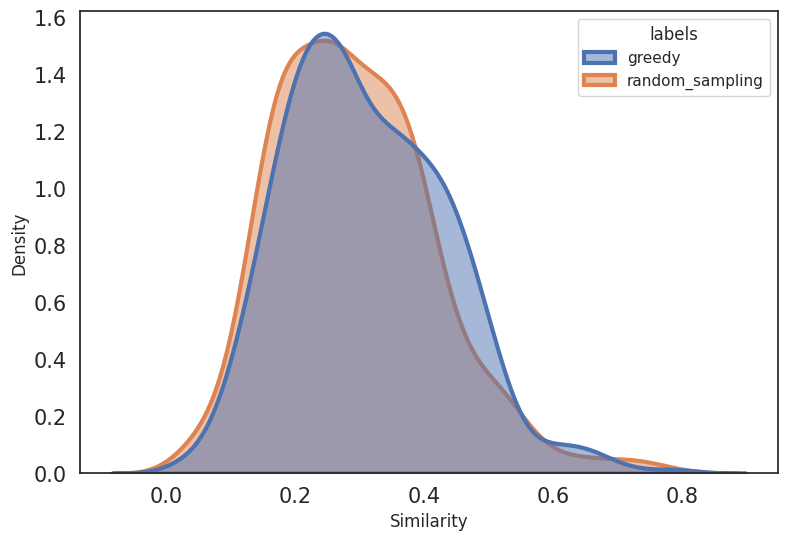

In [59]:
df = pd.DataFrame()
df['Similarity'] = sims
df['labels'] = sims_labels
%matplotlib inline
sns.set(rc={'figure.figsize':(9,6)})
sns.set_style("white")
sns.kdeplot(df, x='Similarity', hue='labels', fill=True, alpha=0.5, linewidth=3, common_norm=True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('./images/tanimotosim.png', dpi=300)

In [56]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
opts = Draw.DrawingOptions()
Draw.SetComicMode(opts)

img = Draw.MolsToGridImage(arr[10:50], molsPerRow=5, returnPNG=False)
# img.save('./images/Decoder_rdkit_vis.png' )

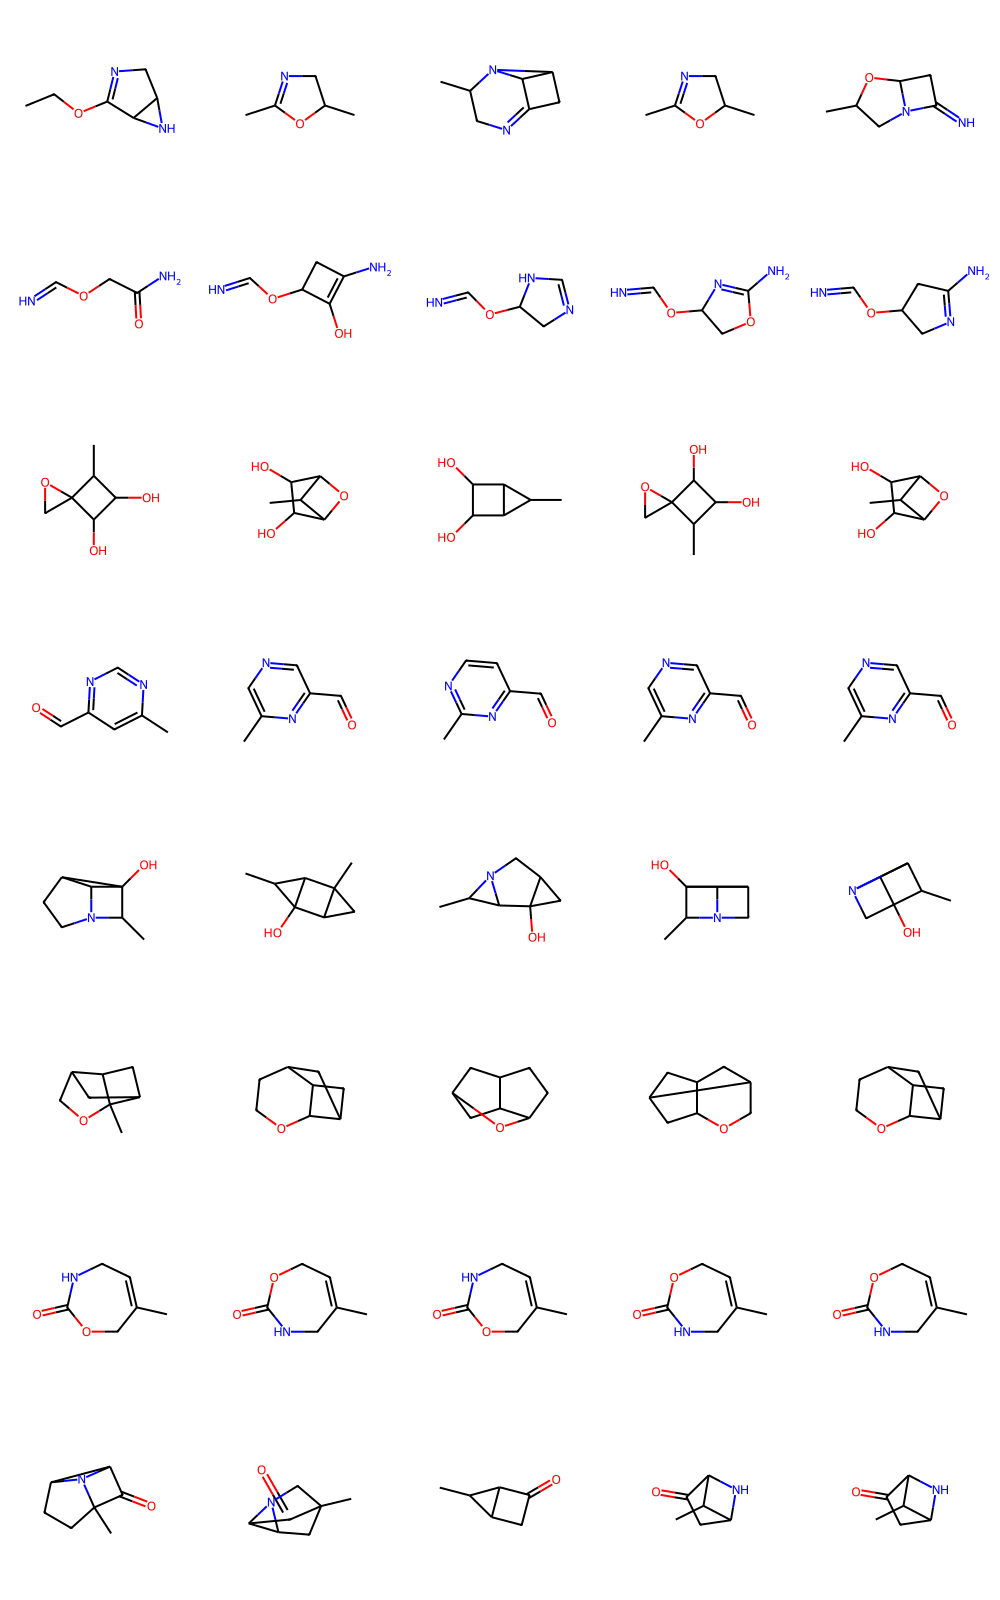

In [57]:
img

<AxesSubplot: xlabel='Similarity', ylabel='Count'>

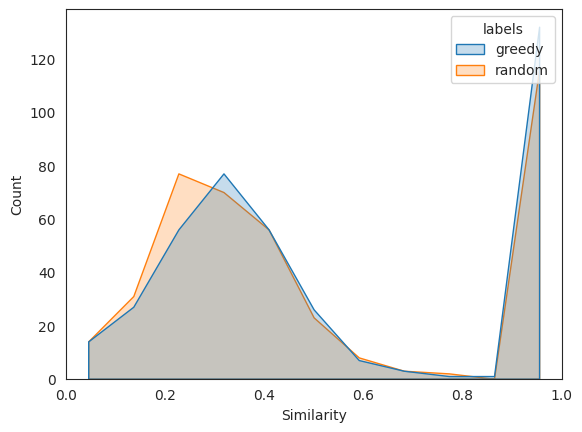

In [ ]:
len(random_smiles_list[0])

3

In [ ]:
len(arr)

0

RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 214 in file Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2022.09.1
	BOOST: 1_78
